In [2]:
from pathlib import Path
from datetime import datetime
import fiona
import numpy as np
from distributed import Client, performance_report
from dask_jobqueue import SLURMCluster

###############################################################################

system = 'lrz' # 'draco', 'm1'
vec_name = 'malalane'

###############################################################################
if system == 'draco':
    s1_rtc_dir = '/geonfs/04_vol1/Saldi/original_data/Sentinel1/s1_rtc'
elif system == 'lrz':
    s1_rtc_dir = '/datacube/original_data/Sentinel1/s1_rtc'
else:
    s1_rtc_dir = None

cwd = Path.cwd()
out_dir = cwd.joinpath('results', 's1_ratio_db_median', {'m1': f'local_{system}', 'lrz': f'hpc_{system}',
                                                         'draco': f'hpc_{system}'}[system])
vec = cwd.joinpath('vec', f'{vec_name}.geojson')
now = datetime.now().strftime('%Y%m%dT%H%M')

product = 's1_rtc'
measurements = ('vh', 'vv')
time_range = ('2019-01-01', '2020-12-31')
bbox = fiona.open(vec, 'r').bounds
x = (bbox[0], bbox[2])
y = (bbox[1], bbox[3])
output_crs = 'EPSG:4326'
resolution = (-0.0002, 0.0002)
resampling = 'bilinear'
dask_chunks = {'time': 1, 'latitude': 256, 'longitude': 256}
dask_rechunk = {'time': -1}

###############################################################################

n_workers = 1
threads_per_worker = 20
mem_limit = "50GB"

if system in ['m1', 'lrz']:
    dask_client = Client(processes=False, n_workers=n_workers, threads_per_worker=threads_per_worker, memory_limit=mem_limit)
elif system == 'draco':
    cluster = SLURMCluster(cores=threads_per_worker, processes=n_workers, memory=mem_limit, walltime="01:00:00")
    dask_client = Client(cluster)
    cluster.scale(jobs=1)
    cluster
else:
    raise RuntimeError(f"System '{system}' not recognized. Should be 'm1', 'lrz' or 'draco'")

# 1. STAC metadata - local

In [3]:
from pystac import Catalog
from utils import create_in_memory_stac_hierarchy, filter_stac_catalog

run_this = True
if system == 'lrz':
    catalog = create_in_memory_stac_hierarchy(root_dir=Path("/datacube/original_data/Sentinel1/s1_rtc"))
elif system == 'draco':
    catalog = Catalog.from_file("/geonfs/04_vol1/Saldi/original_data/Sentinel1/s1_rtc/catalog.json")
else:
    catalog = None
    run_this = False
    print(f"This part is not implemented for system '{system}' and the following code blocks will be skipped.")

In [4]:
if not run_this:
    collections, items = None, None
    print('Skipping...')
else:
    catalog.make_all_asset_hrefs_absolute()
    collections, items = filter_stac_catalog(catalog=catalog, bbox=bbox, time_range=time_range)
    print(len(items))

169


/home/datacube/micromamba/envs/stac-access-2/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## 1.1. odc-stac

(169, 777, 1188)


/home/datacube/micromamba/envs/stac-access-2/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 9min 20s, sys: 2min 1s, total: 11min 21s
Wall time: 1min 54s


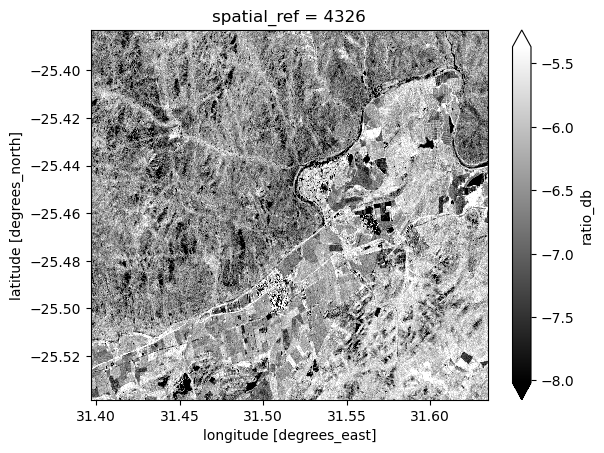

In [5]:
%%time
if not run_this:
    print('Skipping...')
else:
    from odc.stac import load as stac_load

    data_odcstac_local = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                                   resampling=resampling, chunks=dask_chunks)
    data_odcstac_local['ratio_db'] = 10 * np.log10(data_odcstac_local.vh / data_odcstac_local.vv)
    data_odcstac_local = data_odcstac_local.chunk(chunks=dask_rechunk)
    print(data_odcstac_local.ratio_db.shape)
    
    with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-local-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
        result_odcstac_local = data_odcstac_local.ratio_db.median(dim='time', skipna=True).compute()
    
    result_odcstac_local.plot(robust=True, cmap='gray')

## 1.2. stackstac

/home/datacube/micromamba/envs/stac-access-2/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


(169, 777, 1188)


/home/datacube/micromamba/envs/stac-access-2/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 7min 56s, sys: 26.6 s, total: 8min 22s
Wall time: 1min 50s


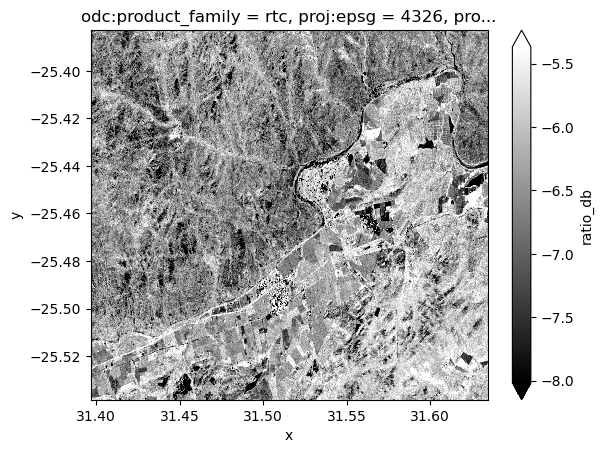

In [6]:
%%time
if not run_this:
    print('Skipping...')
else:
    import stackstac
    from rasterio.enums import Resampling

    chunksize = (1,) + tuple(dask_chunks.values())
    data_stackstac_local = stackstac.stack(items=items, assets=list(measurements), bounds=bbox, epsg=int(output_crs.removeprefix("EPSG:")),
                                           resolution=resolution[1], resampling=Resampling[resampling], chunksize=chunksize, dtype=np.float32)
    vh = data_stackstac_local.sel(band='vh')
    vv = data_stackstac_local.sel(band='vv')
    data_stackstac_local['ratio_db'] = 10 * np.log10(vh / vv)
    data_stackstac_local = data_stackstac_local.chunk(chunks=dask_rechunk)
    
    print(data_stackstac_local.ratio_db.shape)
    
    with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-local-stackstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
        result_stackstac_local = data_stackstac_local.ratio_db.median(dim='time', skipna=True).compute()
    
    result_stackstac_local.plot(robust=True, cmap='gray')

# 2. EO3 metadata - local - datacube-core

[1] https://github.com/opendatacube/datacube-core  
[2] https://datacube-core.readthedocs.io/en/latest/installation/dataset-documents.html?highlight=eo3#eo3-format

In [7]:
if system == 'lrz':
    run_this = True
else:
    run_this = False
    print(f"This part is not implemented for system '{system}' and the following code blocks will be skipped.")

(169, 777, 1188)


/home/datacube/micromamba/envs/stac-access-2/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 9min 24s, sys: 1min 49s, total: 11min 14s
Wall time: 1min 59s


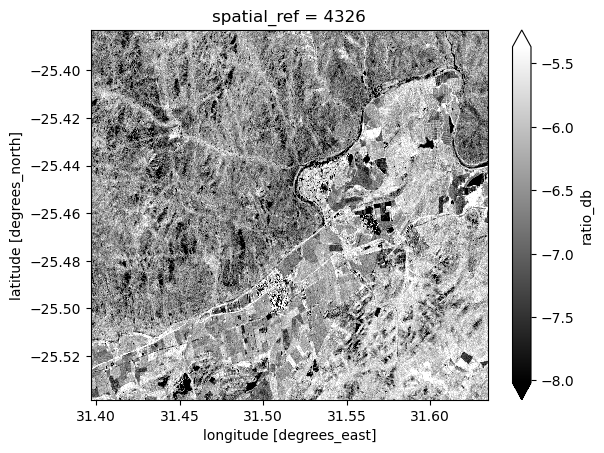

In [8]:
%%time
if not run_this:
    print('Skipping...')
else:
    import datacube
    dc = datacube.Datacube()
    data_dc_local = dc.load(product=product, measurements=list(measurements), x=x, y=y, time=time_range,
                            output_crs=output_crs, resolution=resolution, resampling=resampling,
                            dask_chunks=dask_chunks)

    data_dc_local['ratio_db'] = 10 * np.log10(data_dc_local.vh / data_dc_local.vv)
    data_dc_local = data_dc_local.chunk(chunks=dask_rechunk)
    
    print(data_dc_local.ratio_db.shape)
    
    with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_eo3-local-datacube_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
        result_dc_local = data_dc_local.ratio_db.median(dim='time', skipna=True).compute()
        
    result_dc_local.plot(robust=True, cmap='gray')

# 3. STAC metadata - remote - odc-stac

[3] https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html

In [9]:
from odc.stac import configure_rio
import pystac_client

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com", client=dask_client)
remote_catalog = pystac_client.Client.open("https://explorer.digitalearth.africa/stac")
items = remote_catalog.search(bbox=bbox, collections=[product], datetime=f"{time_range[0]}/{time_range[1]}", max_items=None).get_all_items()
print(len(items))

169


(169, 777, 1188)


/home/datacube/micromamba/envs/stac-access-2/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 21min 17s, sys: 11min 38s, total: 32min 55s
Wall time: 27min 50s


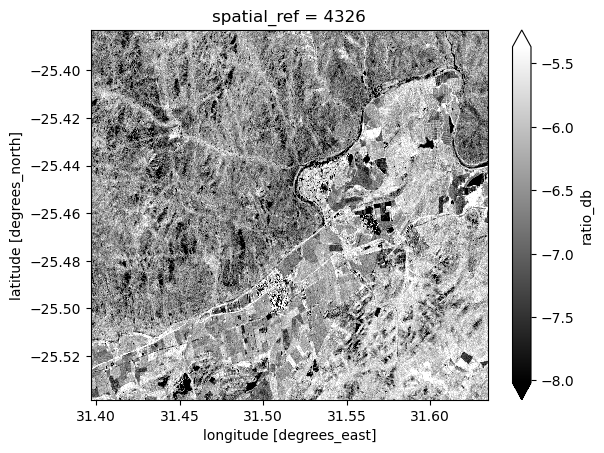

In [10]:
%%time
from odc.stac import load as stac_load

data_odcstac_remote = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                                resampling=resampling, chunks=dask_chunks)
data_odcstac_remote['ratio_db'] = 10 * np.log10(data_odcstac_remote.vh / data_odcstac_remote.vv)
data_odcstac_remote = data_odcstac_remote.chunk(chunks=dask_rechunk)

print(data_odcstac_remote.ratio_db.shape)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-remote-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_odcstac_remote = data_odcstac_remote.ratio_db.median(dim='time', skipna=True).compute()

result_odcstac_remote.plot(robust=True, cmap='gray')

# Additional information

In [11]:
import datacube
import odc.stac
import odc.geo
import stackstac
import rasterio
import pystac
import pystac_client
print(f"datacube=={datacube.__version__}")
print(f"odc.stac=={odc.stac.__version__}")
print(f"odc.geo=={odc.geo.__version__}")
print(f"stackstac=={stackstac.__version__}")
print(f"rasterio=={rasterio.__version__}")
print(f"pystac=={pystac.__version__}")
print(f"pystac_client=={pystac_client.__version__}")

datacube==1.8.13
odc.stac==0.3.6
odc.geo==0.3.3
stackstac==0.4.3
rasterio==1.3.7
pystac==1.7.3
pystac_client==0.6.1


In [12]:
if system in ['lrz', 'draco']:
    !lscpu | grep -v "Vulnerability" | grep -v "Flags"
else:
    !system_profiler SPSoftwareDataType SPHardwareDataType | grep -E "System Version|Model Name|Chip|Cores|Memory"

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 57 bits virtual
CPU(s):                          40
On-line CPU(s) list:             0-39
Thread(s) per core:              1
Core(s) per socket:              1
Socket(s):                       40
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           106
Model name:                      Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
Stepping:                        6
CPU MHz:                         2294.562
BogoMIPS:                        4589.12
Virtualization:                  VT-x
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       1.3 MiB
L1i cache:                       1.3 MiB
L2 cache:                        160 MiB
L3 cache:                        64